In [ ]:
!pip install librosa soundfile tensorflow scikit-learn matplotlib seaborn tqdm -q


In [ ]:
import os, glob, re, pandas as pd, numpy as np

DATASET_DIR = "/content/drive/MyDrive/audio lstm cnn"
files = glob.glob(os.path.join(DATASET_DIR, "Actor_*/*.wav"))

EMOTION_MAP = {
    '01': 'neutral','02': 'calm','03': 'happy','04': 'sad',
    '05': 'angry','06': 'fearful','07': 'disgust','08': 'surprised'
}

def parse_emotion(f):
    parts = re.findall(r'\d{2}', os.path.basename(f))
    emotion = EMOTION_MAP.get(parts[2], 'unknown')
    actor = int(parts[-1])
    return emotion, actor

data = []
for f in files:
    emotion, actor = parse_emotion(f)
    if emotion != 'unknown':
        data.append((f, emotion, actor))

df = pd.DataFrame(data, columns=['path', 'emotion', 'actor'])
df.head()


,path,emotion,actor
0,/content/drive/MyDrive/audio lstm cnn/Actor_05...,calm,5
1,/content/drive/MyDrive/audio lstm cnn/Actor_05...,happy,5
2,/content/drive/MyDrive/audio lstm cnn/Actor_05...,calm,5
3,/content/drive/MyDrive/audio lstm cnn/Actor_05...,happy,5
4,/content/drive/MyDrive/audio lstm cnn/Actor_05...,sad,5


In [ ]:
train_actors = list(range(1, 21))   # 20 actors for training
test_actors  = list(range(21, 25))  # 4 actors for testing

train_df = df[df['actor'].isin(train_actors)]
test_df  = df[df['actor'].isin(test_actors)]

print(f"Train: {len(train_df)}, Test: {len(test_df)}")


Train: 1200, Test: 240


In [ ]:
import librosa, numpy as np
from tqdm import tqdm

SAMPLE_RATE = 22050
N_MFCC = 40
MAX_PAD_LEN = 216

def extract_features(path):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, duration=4.0)
    stft = np.abs(librosa.stft(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    feats = np.vstack([mfcc, chroma, contrast, tonnetz])
    if feats.shape[1] < MAX_PAD_LEN:
        feats = np.pad(feats, ((0, 0), (0, MAX_PAD_LEN - feats.shape[1])), 'constant')
    else:
        feats = feats[:, :MAX_PAD_LEN]
    return feats


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_features(df):
    X, y = [], []
    for p, e in tqdm(zip(df['path'], df['emotion']), total=len(df)):
        X.append(extract_features(p))
        y.append(e)
    X = np.array(X)[..., np.newaxis]
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    y_cat = to_categorical(y_enc)
    return X, y_cat, le

X_train, y_train, le = load_features(train_df)
X_test, y_test, _ = load_features(test_df)


 91%|█████████ | 1090/1200 [13:43<01:11,  1.53it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(
100%|██████████| 240/240 [02:55<00:00,  1.37it/s]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Bidirectional, LSTM, Dense

input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Reshape((-1, 128)),                 # dynamic reshape
    Bidirectional(LSTM(64)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 65, 216, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 216, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 216, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,928 (820.03 KB)

 Trainable params: 209,480 (818.28 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

cw = compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
cw = dict(enumerate(cw))

cb = [
    ModelCheckpoint("/content/drive/MyDrive/ravdess_best_model.h5",
                    monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=40,
    batch_size=32,
    class_weight=cw,
    callbacks=cb,
    verbose=1
)


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1517 - loss: 2.0946
Epoch 1: val_accuracy improved from -inf to 0.13333, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.1525 - loss: 2.0945 - val_accuracy: 0.1333 - val_loss: 2.0694
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1733 - loss: 2.0298
Epoch 2: val_accuracy improved from 0.13333 to 0.18889, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.1740 - loss: 2.0284 - val_accuracy: 0.1889 - val_loss: 2.1068
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2381 - loss: 1.9381
Epoch 3: val_accuracy improved from 0.18889 to 0.19444, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.2379 - loss: 1.9382 - val_accuracy: 0.1944 - val_loss: 1.9764
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2989 - loss: 1.8594
Epoch 4: val_accuracy improved from 0.19444 to 0.22222, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.2985 - loss: 1.8592 - val_accuracy: 0.2222 - val_loss: 1.9446
Epoch 5/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3212 - loss: 1.7645
Epoch 5: val_accuracy did not improve from 0.22222
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3209 - loss: 1.7648 - val_accuracy: 0.2056 - val_loss: 1.9438
Epoch 6/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3132 - loss: 1.7052
Epoch 6: val_accuracy improved from 0.22222 to 0.26667, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3134 - loss: 1.7071 - val_accuracy: 0.2667 - val_loss: 1.8620
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3203 - loss: 1.6982
Epoch 7: val_accuracy did not improve from 0.26667
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3207 - loss: 1.6982 - val_accuracy: 0.2111 - val_loss: 2.0255
Epoch 8/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3146 - loss: 1.7629
Epoch 8: val_accuracy did not improve from 0.26667
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3138 - loss: 1.7621 - val_accuracy: 0.2111 - val_loss: 1.9047
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3158 - loss: 1.7181
Epoch 9: val_accuracy did not improve from 0.26667
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3159 - loss: 1.7176 - val_accuracy: 0.2056 - val_loss: 1.9679
Epoch 10/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3154 - loss: 1.6848
Epoch 10: val_accuracy did not improve fro

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.3101 - loss: 1.6849 - val_accuracy: 0.2778 - val_loss: 1.8741
Epoch 12/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3494 - loss: 1.6139
Epoch 12: val_accuracy improved from 0.27778 to 0.34444, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3505 - loss: 1.6133 - val_accuracy: 0.3444 - val_loss: 1.7692
Epoch 13/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3688 - loss: 1.5920
Epoch 13: val_accuracy improved from 0.34444 to 0.35556, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3686 - loss: 1.5928 - val_accuracy: 0.3556 - val_loss: 1.7320
Epoch 14/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4014 - loss: 1.5741
Epoch 14: val_accuracy improved from 0.35556 to 0.36111, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4010 - loss: 1.5740 - val_accuracy: 0.3611 - val_loss: 1.7262
Epoch 15/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4018 - loss: 1.5241
Epoch 15: val_accuracy did not improve from 0.36111
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4016 - loss: 1.5248 - val_accuracy: 0.3500 - val_loss: 1.8502
Epoch 16/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3991 - loss: 1.5717
Epoch 16: val_accuracy improved from 0.36111 to 0.40556, saving model to /content/drive/MyDrive/ravdess_best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3987 - loss: 1.5712 - val_accuracy: 0.4056 - val_loss: 1.6341
Epoch 17/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4106 - loss: 1.5027
Epoch 17: val_accuracy did not improve from 0.40556
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4120 - loss: 1.5007 - val_accuracy: 0.3889 - val_loss: 1.6834
Epoch 18/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4267 - loss: 1.4603
Epoch 18: val_accuracy did not improve from 0.40556
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4267 - loss: 1.4617 - val_accuracy: 0.3056 - val_loss: 1.7261
Epoch 19/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4559 - loss: 1.4245
Epoch 19: val_accuracy did not improve from 0.40556
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4560 - loss: 1.4251 - val_accuracy: 0.3778 - val_loss: 1.5791
Epoch 20/40
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4260 - loss: 1.4275
Epoch 20: val_accuracy did not impro

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3125 - loss: 1.7376
Test accuracy: 37.08%
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
              precision    recall  f1-score   support

       angry       0.40      0.59      0.47        32
        calm       0.60      0.56      0.58        32
     disgust       0.28      0.69      0.40        32
     fearful       0.55      0.19      0.28        32
       happy       0.31      0.12      0.18        32
     neutral       0.12      0.12      0.12        16
         sad       0.38      0.16      0.22        32
   surprised       0.42      0.41      0.41        32

    accuracy                           0.37       240
   macro avg       0.38      0.36      0.33       240
weighted avg       0.40      0.37      0.35       240



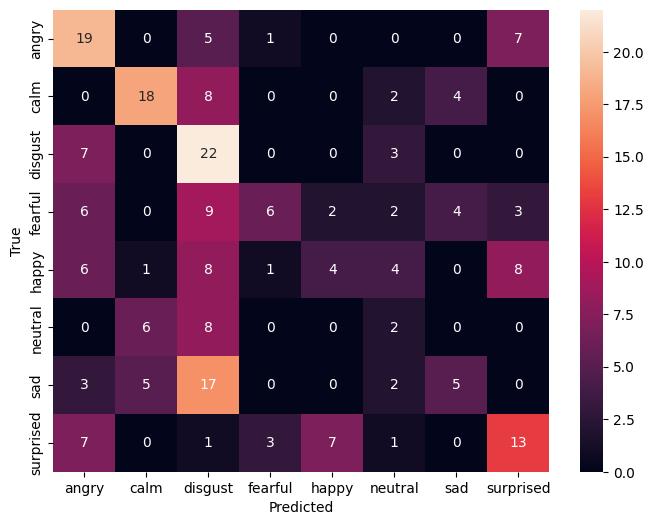

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [ ]:
import pickle
model.save("/content/drive/MyDrive/ravdess_crnn_model.h5")
with open("/content/drive/MyDrive/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
